# Entender o Problema

- Objetivo do Problema:
    - Predição de qual país será o primeiro destino de reserva de um novo usuário;
    - Porque?
        - Qual o tipo de modelo de negócio do Airbnb?
            - Marketplace (conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação)
            - Oferta (pessoas oferecendo acomodação)
                - Tamanho do portifólio
                - Diversisdade/Densidade de Portfólio
                - preço Médio
            - Demanda (pessoas procurando acomodação)
                - Número de Usuários
                - LTV (Lifetime Value)
                - CAC ( Client Acquisition Cost)

        Gross Revenue = (Fee*Numero cliente) - CAC

- Proposta de Solução:
    - Modelo de Previsão do primeiro destino de um novo usuário
    - 1.0. Predições salvas em uma tabela do banco de dados
    - 2.0. API
        - Input: usuário e suas características
        - Output: usuário e suas características com a predição de destino

# <font color='red'>Ciclo 01: End to End</font>

# 0.0. Imports

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt

from keras import models as ml
from keras.layers import Dense, Dropout

import tensorflow as tf


## 0.1. Helper Functions

## 0.2. Loading Data

In [6]:
df_users_raw = pd.read_csv('../data/train_users_2.csv', low_memory=True)
df_users_raw.shape

(213451, 16)

In [7]:
df_sessions_raw = pd.read_csv('../data/sessions.csv', low_memory=True)
df_sessions_raw.shape

(10567737, 6)

# 1.0 Data Description

In [8]:
df1 = df_users_raw.copy()

## 1.1. Data Dimension

In [9]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of rows 213451
Number of columns 16


In [10]:
print('Number of rows {}'.format(df_sessions_raw.shape[0]))
print('Number of columns {}'.format(df_sessions_raw.shape[1]))

Number of rows 10567737
Number of columns 6


## 1.2. Data Types

In [11]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [12]:
df_sessions_raw.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check NAs

In [13]:
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [14]:
df_sessions_raw.isna().sum()/len(df_sessions_raw)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

/home/leonam/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='secs_elapsed', ylabel='Density'>

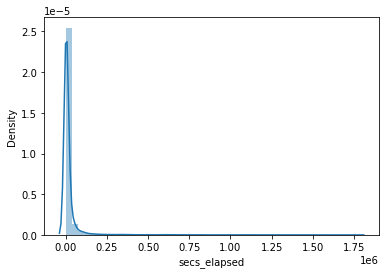

In [15]:
sns.distplot(df_sessions_raw['secs_elapsed'].sample(10000))

## 1.4. Fillout NAs

In [16]:
# remiove missing values
# df1 = df1.dropna()


# =============== User ===================

# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age - NA está distribuido entre as classes
# Distribuição de age se parece com uma normal
# sns.distplot(df1[df1['age'] < 65.0]['age'])
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked - fazer replacement de dados categoricos é perigoso com chance de enviesar o modelo
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# =============== Sessions ===================
# Como df_sessions_raw possui um número muito grande amostras (10567737), serão removidas todas as amostras 
# que possuem dados NA 

# user_id          0.3%
df_sessions_raw = df_sessions_raw[df_sessions_raw['user_id'].notna()]

# action           0.7%
df_sessions_raw = df_sessions_raw[df_sessions_raw['action'].notna()]

# action_type      10.6570%
df_sessions_raw = df_sessions_raw[df_sessions_raw['action_type'].notna()]

# action_detail    10.6570%
df_sessions_raw = df_sessions_raw[df_sessions_raw['action_detail'].notna()]

# secs_elapsed     1.2872%
df_sessions_raw = df_sessions_raw[df_sessions_raw['secs_elapsed'].notna()]


## 1.4. Change Types

In [17]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'], format='%Y-%m-%d')

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'], format='%Y-%m-%d')

# age
df1['age'] = df1['age'].astype(int)

## 1.5 Check Balanced Data

In [18]:
# response variable is the columns country_destination
df1['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

# 2.0. Feature Engineering

In [19]:
df2 = df1.copy()

# 3.0. Feature Filtering

## 3.1. Filtering Rows

## 3.2 Columns Selection

# 4.0. Exploratory Data Analysis

# 5.0. Data Preparation

In [20]:
df5 = df2.copy()

In [21]:
# dummy variable
df5_dummy = pd.get_dummies(df5.drop(['id', 'country_destination'], axis=1))

# join id and country destination
df5 = pd.concat([df5[['id', 'country_destination']], df5_dummy], axis=1)

# 6.0 Feature Selection

In [22]:
df6 = df5.copy()
cols_drop = ['id', 'date_account_created', 'timestamp_first_active', 'date_first_booking'] #original dates

df6 = df6.drop(cols_drop, axis=1)

# 7.0. Machine Learning Model

In [23]:
X = df6.drop('country_destination', axis=1)
y = df6[['country_destination']]

In [24]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

### Viés de Seleção: 

- Utilizando train_test_split posso "dar sorte" de selecionar uma boa amostra do meu conjunto de dados para treino e uma pessima amostra do conjunto de dados para teste

- Alguns comportamentos podem esar escondidos em amostras não selecionadas

- O comportamento dos dados de treino podem estar diferentes dos dados de teste


### Solução: 
- Amostrar o conjunto de dados mais vezes, para aumentar a chance do modelo aprender todos os padrões dos dados

### **Cross-Validation**

- K-Fold (5 a 10 folds)
- leave_one-Out -> super custoso mas garante que todos os possiveis padrões dos dados sejam vistos pelo modelo
- Não Funciona muito bem para séries temporais
- Não Funciona muito bem com dados desbalanceados

## 7.1.1. Baseline Model

In [25]:
country_destination_list = df6['country_destination'].drop_duplicates().sort_values().tolist()
country_destination_weights = df6['country_destination'].value_counts(normalize=True).sort_index().tolist()

# modelo que chuta de forma aleatória
yhat_random = random.choices(population=country_destination_list, 
                             k=len(y_test), 
                             weights= country_destination_weights)

Accuracy: 0.42936014272626455
Balanced Accuracy: 0.08269199016741917
Kappa Score: 0.005214452378658918
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       111
          CA       0.00      0.00      0.00       281
          DE       0.00      0.00      0.00       215
          ES       0.01      0.01      0.01       428
          FR       0.02      0.02      0.02      1021
          GB       0.01      0.01      0.01       426
          IT       0.01      0.01      0.01       570
         NDF       0.58      0.58      0.58     23996
          NL       0.01      0.01      0.01       146
          PT       0.00      0.00      0.00        48
          US       0.30      0.30      0.30     12280
       other       0.05      0.05      0.05      1956

    accuracy                           0.43     41478
   macro avg       0.08      0.08      0.08     41478
weighted avg       0.43      0.43      0.43     41478



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

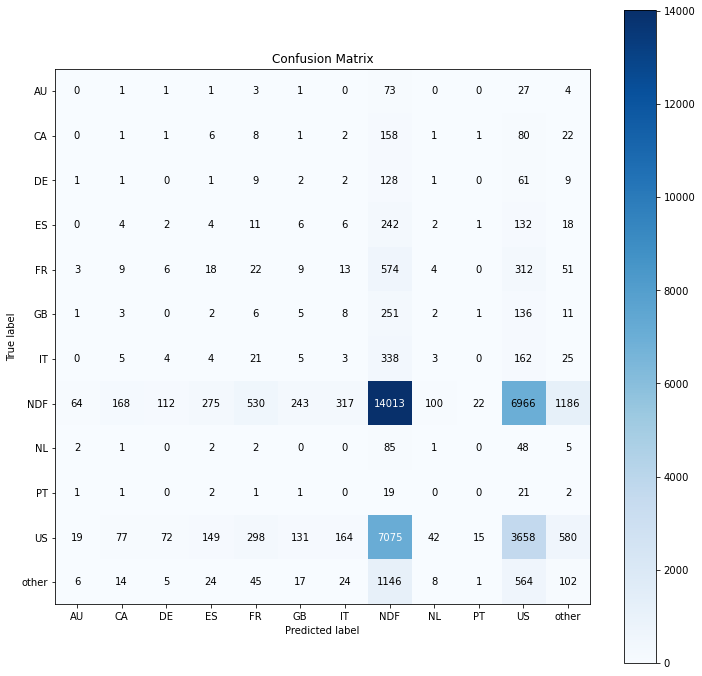

In [26]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random, zero_division=0))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12))

## 7.1.2. Neral Network - MLP

In [27]:
# Categorically encode labels
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [29]:
# moel definition
model = ml.Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(12, activation='softmax'))

# model compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train model
model.fit(X_train, y_train_nn, epochs=50)

Epoch 1/50


2021-10-15 15:46:39.591615: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


165908/165908 [==============================] - 12s 70us/step - loss: 1.2596 - accuracy: 0.5845
Epoch 2/50
165908/165908 [==============================] - 9s 53us/step - loss: 1.1495 - accuracy: 0.6070
Epoch 3/50
165908/165908 [==============================] - 9s 53us/step - loss: 1.1077 - accuracy: 0.6161
Epoch 4/50
165908/165908 [==============================] - 9s 57us/step - loss: 1.0929 - accuracy: 0.6182
Epoch 5/50
165908/165908 [==============================] - 10s 58us/step - loss: 1.0890 - accuracy: 0.6196
Epoch 6/50
165908/165908 [==============================] - 9s 53us/step - loss: 1.0870 - accuracy: 0.6202
Epoch 7/50
165908/165908 [==============================] - 8s 50us/step - loss: 1.0853 - accuracy: 0.6217
Epoch 8/50
165908/165908 [==============================] - 9s 51us/step - loss: 1.0840 - accuracy: 0.6217
Epoch 9/50
165908/165908 [==============================] - 9s 52us/step - loss: 1.0832 - accuracy: 0.6222
Epoch 10/50
165908/165908 [===================

In [30]:
# prediction
pred_nn = model.predict(X_test)

# invert prediction
yhat_nn = np.ravel(ohe.inverse_transform(pred_nn))

# prediction prepare
y_test_nn = np.ravel(y_test.to_numpy())

Accuracy: 0.6258257389459473
Balanced Accuracy: 0.10702229482172983
Kappa Score: 0.23705121133999996
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       111
          CA       0.00      0.00      0.00       281
          DE       0.00      0.00      0.00       215
          ES       0.00      0.00      0.00       428
          FR       0.12      0.00      0.00      1021
          GB       0.00      0.00      0.00       426
          IT       0.00      0.00      0.00       570
         NDF       0.67      0.87      0.75     23996
          NL       0.00      0.00      0.00       146
          PT       0.00      0.00      0.00        48
          US       0.50      0.41      0.45     12280
       other       0.07      0.00      0.00      1956

    accuracy                           0.63     41478
   macro avg       0.11      0.11      0.10     41478
weighted avg       0.54      0.63      0.57     41478



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

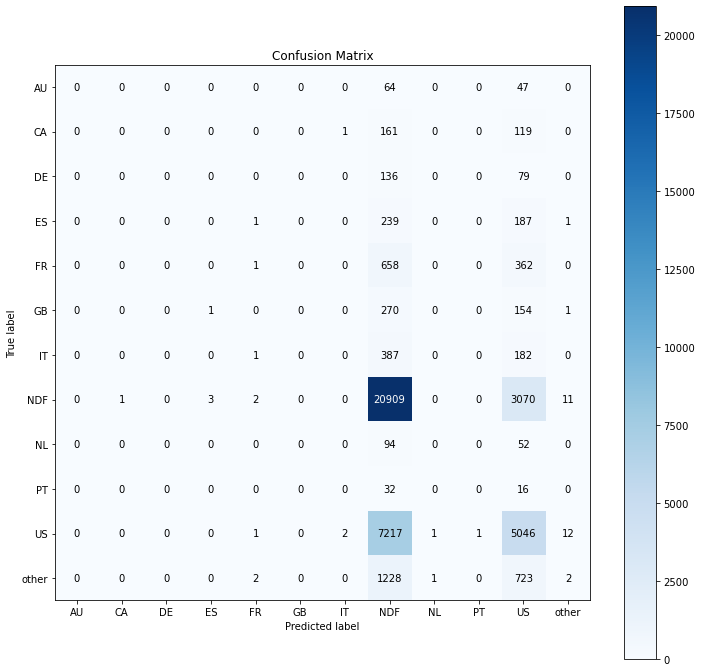

In [32]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn, zero_division=0))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

## **O Problema:** 
A acurácia não é uma métrica ideal para representar a performance do modelo.

### **Possíveis Causas:**

* Falta de Features Representativas do Fenômeno;
* Dados com Ruídos ("Sujeira")
* Escasses de exemplos de treino para outras classes (dados desbalanceados).
* Divergência entre o Viés dos Dados eo Viés do Modelo (è o modelo mais adequado?)

## Métricas:

### Accuracy:  
- Contar Quantas <font color='red'>**Predições**</font> foram <font color='red'>**Corretas**</font> e Dividir por todas as <font color='blue'>Predições</font> <font color='blue'>Realizadas</font>  pelo modelo.


$$Acurácia = \frac{Número de Predições Corretas}{Número de Predições Realizadas}$$

$$Acurácia = \frac{9528}{13635} = 69.87\%$$

### Precision:  
- Contar Quantas <font color='red'>**Predições**</font> foram <font color='red'>**Corretas**</font> e Dividir por todas as <font color='blue'>Predições</font> <font color='blue'>Realizadas</font>  pelo modelo em cada Classe.


$$Acurácia = \frac{Número de Predições Corretas Classe FR}{Número de Predições Classe FR}$$

$$Acurácia = \frac{3}{26} = 11.54\%$$

- Métrica útil quando uma das classes do problema possui certa prioridade.

### Recall (Sensitividade): 
- Contar Quantas <font color='red'>**Predições**</font> foram <font color='red'>**Corretas**</font> e Dividir por todos os <font color='blue'>Exemplos Reais</font> de cada Classe.

$$Recall = \frac{Número de Predições Corretas Classe FR}{Total de Exemplos da Classe FR}$$

$$Recall = \frac{3}{710} = 0.42\%$$

### F1-Score: 
- Média entre Precision e Recall.
    - Média Harmônica

$$F1-Score = 2*\frac{Precision * Recall}{precision + Recall}$$

$$F1-Score = 2*\frac{0.115 * 0.004}{0.115 * 0.004} = 0.008 $$

- Calcula-se F1-score para cada uma das classes, sendo ideal para problemas de classificação binários. Para problemas multiclasse não é recomendável a utilização dessa métrica, pois terá que ser calculada para cada uma das classes.

## Precisamos de <font color='red'>uma ÚNICA Métrica</font> que diga a <font color='blue'>Performance</font> do Modelo.

### Balanced Accuracy: 
-Média das Acurácias de Cada Classe

$$Balanced Accuracy = \frac{1}{NClasses} \sum_{i=1}^{NClasses} \frac{PredCorretasClass_i}{TotalPredClass_i} $$

$$Balanced Accuracy = 9\%$$


### Kappa Score: 
-Médir o Nível de Acordo entre 2 Avaliadores

$$KappaScore= \frac{\#NidelDeAcordo - (\#NivelDeAcordoAoAcaso)}{1- \#NivelDeAcordoAoAcaso}  $$

$$NivelDeAcordoAoAcaso = Prob_A * Prob_B$$



## 7.3. NN Performance - Cross- Validation

In [ ]:
# generate k-fold
num_folds=5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_score_list = []

i=1
for train_ix, val_ix in kfold.split(X_train, y_train):
    
    print('Fold Number {}/{}'.format(i, num_folds))
    # get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]

    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    # Categorically encode labels
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()

    # model definition
    model = ml.Sequential()
    model.add(Dense(256, input_dim=x_train_fold.shape[1], activation='relu'))
    model.add(Dense(11, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=50, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold)

    # invert prediction
    yhat_nn = np.ravel(ohe.inverse_transform(pred_nn))
    y_val_nn = np.ravel(y_val_fold)
    
    # metrics
    # Balanced Accuracy
    balanced_acc_list.append(m.balanced_accuracy_score(y_val_nn, yhat_nn))

    # Kappa Metrics
    kappa_score_list.append(m.cohen_kappa_score(y_val_nn, yhat_nn))

    i+=1

pd.DataFrame({'Model Name':	'MLP', 
    'Balanced ACC CV': [str(np.round(np.mean(balanced_acc_list),2)) + ' +/- ' + str(np.round(np.std(balanced_acc_list),2))],
    'KAPPA SCORE CV': [str(np.round(np.mean(kappa_score_list),2)) + ' +/- ' + str(np.round(np.std(kappa_score_list),2))]})


Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,Balanced ACC CV,KAPPA SCORE CV
0,MLP,0.09 +/- 0.0,0.0 +/- 0.0
